In [12]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [13]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [14]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [15]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [16]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [17]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=tf.nn.sigmoid(targetQs))) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                     labels=tf.zeros_like(targetQs))) # 0-1
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    dlossQ /= 2
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [ ]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [19]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [20]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [22]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [24]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dlossA, dlossQ, _ = sess.run([model.d_lossA, model.d_lossQ, model.d_optA], #, model.d_optQ
                                         feed_dict = {model.states: states, 
                                                      model.actions: actions,
                                                      model.targetQs: targetQs, 
                                                      model.rates: rates})
            gloss, _ = sess.run([model.g_loss, model.g_opt], #, model.d_optQ
                                feed_dict = {model.states: states, 
                                             model.actions: actions,
                                             model.targetQs: targetQs, 
                                             model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:15.0000 R:15.0000 rate:0.0300 gloss:1.3733 dlossA:2.0080 dlossQ:0.6292 exploreP:0.9985
Episode:1 meanR:18.5000 R:22.0000 rate:0.0440 gloss:1.3716 dlossA:2.0045 dlossQ:0.6260 exploreP:0.9963
Episode:2 meanR:27.6667 R:46.0000 rate:0.0920 gloss:1.3671 dlossA:1.9789 dlossQ:0.6259 exploreP:0.9918
Episode:3 meanR:26.2500 R:22.0000 rate:0.0440 gloss:1.3599 dlossA:1.9549 dlossQ:0.6288 exploreP:0.9897
Episode:4 meanR:26.6000 R:28.0000 rate:0.0560 gloss:1.3581 dlossA:1.9432 dlossQ:0.6227 exploreP:0.9869
Episode:5 meanR:24.1667 R:12.0000 rate:0.0240 gloss:1.3585 dlossA:1.9491 dlossQ:0.6225 exploreP:0.9857
Episode:6 meanR:22.2857 R:11.0000 rate:0.0220 gloss:1.3611 dlossA:1.9644 dlossQ:0.6244 exploreP:0.9847
Episode:7 meanR:21.7500 R:18.0000 rate:0.0360 gloss:1.3452 dlossA:1.9057 dlossQ:0.6172 exploreP:0.9829
Episode:8 meanR:21.4444 R:19.0000 rate:0.0380 gloss:1.3492 dlossA:1.9101 dlossQ:0.6191 exploreP:0.9811
Episode:9 meanR:21.5000 R:22.0000 rate:0.0440 gloss:1.3487 dlossA:1.9030 

Episode:79 meanR:20.4875 R:23.0000 rate:0.0460 gloss:1.2449 dlossA:1.5797 dlossQ:0.6373 exploreP:0.8503
Episode:80 meanR:20.4198 R:15.0000 rate:0.0300 gloss:1.2603 dlossA:1.6098 dlossQ:0.6477 exploreP:0.8491
Episode:81 meanR:20.4756 R:25.0000 rate:0.0500 gloss:1.2517 dlossA:1.5895 dlossQ:0.6290 exploreP:0.8470
Episode:82 meanR:20.4699 R:20.0000 rate:0.0400 gloss:1.2416 dlossA:1.5717 dlossQ:0.6309 exploreP:0.8453
Episode:83 meanR:20.3690 R:12.0000 rate:0.0240 gloss:1.2245 dlossA:1.5125 dlossQ:0.6291 exploreP:0.8443
Episode:84 meanR:20.3294 R:17.0000 rate:0.0340 gloss:1.2436 dlossA:1.5638 dlossQ:0.6041 exploreP:0.8429
Episode:85 meanR:20.5814 R:42.0000 rate:0.0840 gloss:1.2334 dlossA:1.5323 dlossQ:0.6386 exploreP:0.8394
Episode:86 meanR:20.5517 R:18.0000 rate:0.0360 gloss:1.2361 dlossA:1.5407 dlossQ:0.5883 exploreP:0.8379
Episode:87 meanR:20.5000 R:16.0000 rate:0.0320 gloss:1.2504 dlossA:1.5790 dlossQ:0.5837 exploreP:0.8366
Episode:88 meanR:20.5618 R:26.0000 rate:0.0520 gloss:1.2217 dlos

Episode:158 meanR:23.4700 R:20.0000 rate:0.0400 gloss:1.1560 dlossA:1.3495 dlossQ:0.5854 exploreP:0.7019
Episode:159 meanR:23.7700 R:41.0000 rate:0.0820 gloss:1.1427 dlossA:1.3255 dlossQ:0.5883 exploreP:0.6991
Episode:160 meanR:23.7800 R:48.0000 rate:0.0960 gloss:1.1673 dlossA:1.3555 dlossQ:0.6686 exploreP:0.6958
Episode:161 meanR:24.1200 R:66.0000 rate:0.1320 gloss:1.1481 dlossA:1.3374 dlossQ:0.5662 exploreP:0.6913
Episode:162 meanR:24.3700 R:37.0000 rate:0.0740 gloss:1.1581 dlossA:1.3441 dlossQ:0.6584 exploreP:0.6888
Episode:163 meanR:24.3500 R:21.0000 rate:0.0420 gloss:1.1462 dlossA:1.3343 dlossQ:0.5583 exploreP:0.6874
Episode:164 meanR:24.8900 R:64.0000 rate:0.1280 gloss:1.1456 dlossA:1.3325 dlossQ:0.5500 exploreP:0.6830
Episode:165 meanR:25.1000 R:35.0000 rate:0.0700 gloss:1.1459 dlossA:1.3303 dlossQ:0.5369 exploreP:0.6807
Episode:166 meanR:25.6800 R:78.0000 rate:0.1560 gloss:1.1438 dlossA:1.3246 dlossQ:0.5421 exploreP:0.6755
Episode:167 meanR:26.2200 R:70.0000 rate:0.1400 gloss:1

Episode:237 meanR:30.7400 R:11.0000 rate:0.0220 gloss:1.1138 dlossA:1.2773 dlossQ:0.5765 exploreP:0.5445
Episode:238 meanR:30.7300 R:12.0000 rate:0.0240 gloss:1.1283 dlossA:1.2879 dlossQ:0.5672 exploreP:0.5438
Episode:239 meanR:30.7000 R:9.0000 rate:0.0180 gloss:1.1396 dlossA:1.3072 dlossQ:0.5323 exploreP:0.5434
Episode:240 meanR:30.6700 R:16.0000 rate:0.0320 gloss:1.1189 dlossA:1.2803 dlossQ:0.5501 exploreP:0.5425
Episode:241 meanR:30.6300 R:13.0000 rate:0.0260 gloss:1.1132 dlossA:1.2715 dlossQ:0.5556 exploreP:0.5418
Episode:242 meanR:30.6300 R:12.0000 rate:0.0240 gloss:1.1071 dlossA:1.2624 dlossQ:0.5772 exploreP:0.5412
Episode:243 meanR:30.3700 R:12.0000 rate:0.0240 gloss:1.1561 dlossA:1.3077 dlossQ:0.6387 exploreP:0.5405
Episode:244 meanR:30.3800 R:19.0000 rate:0.0380 gloss:1.1316 dlossA:1.2931 dlossQ:0.5226 exploreP:0.5395
Episode:245 meanR:30.2300 R:10.0000 rate:0.0200 gloss:1.1168 dlossA:1.2720 dlossQ:0.5397 exploreP:0.5390
Episode:246 meanR:30.0200 R:12.0000 rate:0.0240 gloss:1.

Episode:316 meanR:17.7600 R:15.0000 rate:0.0300 gloss:1.1783 dlossA:1.3678 dlossQ:0.6403 exploreP:0.4804
Episode:317 meanR:17.2700 R:14.0000 rate:0.0280 gloss:1.1268 dlossA:1.3066 dlossQ:0.5849 exploreP:0.4797
Episode:318 meanR:17.0800 R:12.0000 rate:0.0240 gloss:1.1487 dlossA:1.3238 dlossQ:0.5631 exploreP:0.4791
Episode:319 meanR:16.9300 R:11.0000 rate:0.0220 gloss:1.1637 dlossA:1.3397 dlossQ:0.6008 exploreP:0.4786
Episode:320 meanR:16.5600 R:16.0000 rate:0.0320 gloss:1.1584 dlossA:1.3310 dlossQ:0.6087 exploreP:0.4779
Episode:321 meanR:16.3900 R:25.0000 rate:0.0500 gloss:1.1499 dlossA:1.3185 dlossQ:0.5551 exploreP:0.4767
Episode:322 meanR:16.0800 R:13.0000 rate:0.0260 gloss:1.1477 dlossA:1.3124 dlossQ:0.5279 exploreP:0.4761
Episode:323 meanR:15.8800 R:12.0000 rate:0.0240 gloss:1.1356 dlossA:1.2992 dlossQ:0.5213 exploreP:0.4755
Episode:324 meanR:15.8600 R:13.0000 rate:0.0260 gloss:1.1302 dlossA:1.2866 dlossQ:0.5118 exploreP:0.4749
Episode:325 meanR:15.8700 R:22.0000 rate:0.0440 gloss:1

Episode:395 meanR:14.2400 R:16.0000 rate:0.0320 gloss:1.1119 dlossA:1.2574 dlossQ:0.4684 exploreP:0.4306
Episode:396 meanR:14.2600 R:13.0000 rate:0.0260 gloss:1.1312 dlossA:1.2738 dlossQ:0.4629 exploreP:0.4300
Episode:397 meanR:14.1700 R:9.0000 rate:0.0180 gloss:1.1168 dlossA:1.2569 dlossQ:0.4596 exploreP:0.4296
Episode:398 meanR:14.1200 R:9.0000 rate:0.0180 gloss:1.1335 dlossA:1.2721 dlossQ:0.4432 exploreP:0.4293
Episode:399 meanR:14.1100 R:10.0000 rate:0.0200 gloss:1.1212 dlossA:1.2610 dlossQ:0.4643 exploreP:0.4288
Episode:400 meanR:14.1100 R:13.0000 rate:0.0260 gloss:1.1094 dlossA:1.2495 dlossQ:0.4646 exploreP:0.4283
Episode:401 meanR:14.0700 R:11.0000 rate:0.0220 gloss:1.1304 dlossA:1.2688 dlossQ:0.4537 exploreP:0.4278
Episode:402 meanR:14.0800 R:11.0000 rate:0.0220 gloss:1.0969 dlossA:1.2336 dlossQ:0.4325 exploreP:0.4274
Episode:403 meanR:14.1000 R:11.0000 rate:0.0220 gloss:1.1162 dlossA:1.2495 dlossQ:0.4392 exploreP:0.4269
Episode:404 meanR:14.0100 R:11.0000 rate:0.0220 gloss:1.1

Episode:474 meanR:12.4400 R:14.0000 rate:0.0280 gloss:1.0879 dlossA:1.2130 dlossQ:0.4884 exploreP:0.3909
Episode:475 meanR:12.5000 R:19.0000 rate:0.0380 gloss:1.1095 dlossA:1.2238 dlossQ:0.4274 exploreP:0.3902
Episode:476 meanR:12.5000 R:12.0000 rate:0.0240 gloss:1.0747 dlossA:1.2034 dlossQ:0.4623 exploreP:0.3897
Episode:477 meanR:12.5000 R:13.0000 rate:0.0260 gloss:1.1136 dlossA:1.2291 dlossQ:0.4357 exploreP:0.3892
Episode:478 meanR:12.4800 R:10.0000 rate:0.0200 gloss:1.1067 dlossA:1.2261 dlossQ:0.4447 exploreP:0.3888
Episode:479 meanR:12.5000 R:12.0000 rate:0.0240 gloss:1.0794 dlossA:1.2103 dlossQ:0.4828 exploreP:0.3884
Episode:480 meanR:12.5200 R:12.0000 rate:0.0240 gloss:1.1034 dlossA:1.2293 dlossQ:0.4670 exploreP:0.3879
Episode:481 meanR:12.5500 R:15.0000 rate:0.0300 gloss:1.0967 dlossA:1.2255 dlossQ:0.4628 exploreP:0.3874
Episode:482 meanR:12.5100 R:10.0000 rate:0.0200 gloss:1.0866 dlossA:1.2089 dlossQ:0.4502 exploreP:0.3870
Episode:483 meanR:12.4800 R:15.0000 rate:0.0300 gloss:1

Episode:553 meanR:12.5700 R:17.0000 rate:0.0340 gloss:1.1247 dlossA:1.2727 dlossQ:0.4955 exploreP:0.3539
Episode:554 meanR:12.4500 R:11.0000 rate:0.0220 gloss:1.1324 dlossA:1.2782 dlossQ:0.4869 exploreP:0.3535
Episode:555 meanR:12.4900 R:12.0000 rate:0.0240 gloss:1.1416 dlossA:1.2981 dlossQ:0.5328 exploreP:0.3531
Episode:556 meanR:12.5700 R:18.0000 rate:0.0360 gloss:1.1575 dlossA:1.3006 dlossQ:0.4710 exploreP:0.3525
Episode:557 meanR:12.5800 R:14.0000 rate:0.0280 gloss:1.1188 dlossA:1.2617 dlossQ:0.4725 exploreP:0.3520
Episode:558 meanR:12.6700 R:17.0000 rate:0.0340 gloss:1.1326 dlossA:1.2857 dlossQ:0.5085 exploreP:0.3514
Episode:559 meanR:12.7100 R:13.0000 rate:0.0260 gloss:1.1348 dlossA:1.2874 dlossQ:0.4979 exploreP:0.3510
Episode:560 meanR:13.2600 R:69.0000 rate:0.1380 gloss:1.1259 dlossA:1.2839 dlossQ:0.5182 exploreP:0.3486
Episode:561 meanR:13.7700 R:61.0000 rate:0.1220 gloss:1.1432 dlossA:1.3122 dlossQ:0.5777 exploreP:0.3466
Episode:562 meanR:14.5600 R:89.0000 rate:0.1780 gloss:1

Episode:632 meanR:17.5400 R:11.0000 rate:0.0220 gloss:1.1614 dlossA:1.3531 dlossQ:0.5691 exploreP:0.3056
Episode:633 meanR:17.5600 R:12.0000 rate:0.0240 gloss:1.1514 dlossA:1.3441 dlossQ:0.5708 exploreP:0.3053
Episode:634 meanR:17.6200 R:17.0000 rate:0.0340 gloss:1.1738 dlossA:1.3632 dlossQ:0.5572 exploreP:0.3048
Episode:635 meanR:17.6200 R:11.0000 rate:0.0220 gloss:1.1573 dlossA:1.3468 dlossQ:0.5570 exploreP:0.3044
Episode:636 meanR:17.6200 R:10.0000 rate:0.0200 gloss:1.1714 dlossA:1.3607 dlossQ:0.5553 exploreP:0.3042
Episode:637 meanR:17.6300 R:10.0000 rate:0.0200 gloss:1.1430 dlossA:1.3272 dlossQ:0.5449 exploreP:0.3039
Episode:638 meanR:17.6800 R:15.0000 rate:0.0300 gloss:1.1915 dlossA:1.3730 dlossQ:0.5408 exploreP:0.3034
Episode:639 meanR:17.6900 R:11.0000 rate:0.0220 gloss:1.1554 dlossA:1.3343 dlossQ:0.5424 exploreP:0.3031
Episode:640 meanR:17.7400 R:14.0000 rate:0.0280 gloss:1.1483 dlossA:1.3266 dlossQ:0.5276 exploreP:0.3027
Episode:641 meanR:17.8400 R:18.0000 rate:0.0360 gloss:1

Episode:710 meanR:71.5200 R:189.0000 rate:0.3780 gloss:1.3009 dlossA:1.5120 dlossQ:0.5399 exploreP:0.1629
Episode:711 meanR:74.0600 R:266.0000 rate:0.5320 gloss:1.2250 dlossA:1.4340 dlossQ:0.5461 exploreP:0.1589
Episode:712 meanR:78.9500 R:500.0000 rate:1.0000 gloss:1.2671 dlossA:1.4752 dlossQ:0.5481 exploreP:0.1517
Episode:713 meanR:80.9700 R:237.0000 rate:0.4740 gloss:1.2693 dlossA:1.4846 dlossQ:0.5416 exploreP:0.1484
Episode:714 meanR:85.6200 R:500.0000 rate:1.0000 gloss:1.2921 dlossA:1.5114 dlossQ:0.5498 exploreP:0.1416
Episode:715 meanR:89.5700 R:413.0000 rate:0.8260 gloss:1.2949 dlossA:1.5169 dlossQ:0.5395 exploreP:0.1363
Episode:716 meanR:93.0200 R:380.0000 rate:0.7600 gloss:1.2826 dlossA:1.5077 dlossQ:0.5405 exploreP:0.1316
Episode:717 meanR:94.9900 R:325.0000 rate:0.6500 gloss:1.3057 dlossA:1.5287 dlossQ:0.5440 exploreP:0.1277
Episode:718 meanR:97.9600 R:359.0000 rate:0.7180 gloss:1.2986 dlossA:1.5256 dlossQ:0.5444 exploreP:0.1235
Episode:719 meanR:99.8000 R:205.0000 rate:0.41

Episode:788 meanR:171.7600 R:12.0000 rate:0.0240 gloss:1.3208 dlossA:1.5580 dlossQ:0.4632 exploreP:0.0541
Episode:789 meanR:171.3500 R:14.0000 rate:0.0280 gloss:1.3019 dlossA:1.5442 dlossQ:0.4852 exploreP:0.0541
Episode:790 meanR:170.9800 R:16.0000 rate:0.0320 gloss:1.4265 dlossA:1.6630 dlossQ:0.4943 exploreP:0.0540
Episode:791 meanR:170.9500 R:15.0000 rate:0.0300 gloss:1.2216 dlossA:1.4653 dlossQ:0.4714 exploreP:0.0539
Episode:792 meanR:170.5300 R:19.0000 rate:0.0380 gloss:1.3802 dlossA:1.6068 dlossQ:0.4591 exploreP:0.0539
Episode:793 meanR:169.4100 R:27.0000 rate:0.0540 gloss:1.2950 dlossA:1.5311 dlossQ:0.4752 exploreP:0.0537
Episode:794 meanR:168.9600 R:106.0000 rate:0.2120 gloss:1.4051 dlossA:1.6414 dlossQ:0.4836 exploreP:0.0533
Episode:795 meanR:165.8800 R:94.0000 rate:0.1880 gloss:1.3793 dlossA:1.6501 dlossQ:0.5464 exploreP:0.0529
Episode:796 meanR:165.9900 R:87.0000 rate:0.1740 gloss:1.3998 dlossA:1.6902 dlossQ:0.5654 exploreP:0.0525
Episode:797 meanR:164.1600 R:75.0000 rate:0.1

Episode:866 meanR:56.4900 R:11.0000 rate:0.0220 gloss:1.3186 dlossA:1.5644 dlossQ:0.4462 exploreP:0.0406
Episode:867 meanR:55.5900 R:9.0000 rate:0.0180 gloss:1.2549 dlossA:1.5025 dlossQ:0.4490 exploreP:0.0405
Episode:868 meanR:50.7000 R:11.0000 rate:0.0220 gloss:1.5027 dlossA:1.7371 dlossQ:0.4459 exploreP:0.0405
Episode:869 meanR:49.9500 R:9.0000 rate:0.0180 gloss:1.2663 dlossA:1.5158 dlossQ:0.4435 exploreP:0.0405
Episode:870 meanR:49.2900 R:11.0000 rate:0.0220 gloss:1.4183 dlossA:1.6517 dlossQ:0.4573 exploreP:0.0404
Episode:871 meanR:48.7100 R:9.0000 rate:0.0180 gloss:1.3840 dlossA:1.6239 dlossQ:0.4553 exploreP:0.0404
Episode:872 meanR:48.1000 R:11.0000 rate:0.0220 gloss:1.3922 dlossA:1.6263 dlossQ:0.4438 exploreP:0.0404
Episode:873 meanR:47.4900 R:10.0000 rate:0.0200 gloss:1.3614 dlossA:1.5990 dlossQ:0.4465 exploreP:0.0403
Episode:874 meanR:46.9400 R:11.0000 rate:0.0220 gloss:1.4545 dlossA:1.6851 dlossQ:0.4538 exploreP:0.0403
Episode:875 meanR:46.2800 R:11.0000 rate:0.0220 gloss:1.33

Episode:944 meanR:53.4400 R:53.0000 rate:0.1060 gloss:1.3772 dlossA:1.6615 dlossQ:0.5256 exploreP:0.0283
Episode:945 meanR:54.2000 R:86.0000 rate:0.1720 gloss:1.3786 dlossA:1.6596 dlossQ:0.5226 exploreP:0.0281
Episode:946 meanR:55.1300 R:103.0000 rate:0.2060 gloss:1.3433 dlossA:1.6220 dlossQ:0.5421 exploreP:0.0280
Episode:947 meanR:56.1500 R:113.0000 rate:0.2260 gloss:1.3507 dlossA:1.6255 dlossQ:0.5237 exploreP:0.0278
Episode:948 meanR:56.9300 R:91.0000 rate:0.1820 gloss:1.3735 dlossA:1.6448 dlossQ:0.5292 exploreP:0.0276
Episode:949 meanR:57.8500 R:102.0000 rate:0.2040 gloss:1.3909 dlossA:1.6659 dlossQ:0.5261 exploreP:0.0274
Episode:950 meanR:58.8100 R:106.0000 rate:0.2120 gloss:1.3754 dlossA:1.6481 dlossQ:0.5228 exploreP:0.0272
Episode:951 meanR:59.6900 R:98.0000 rate:0.1960 gloss:1.3949 dlossA:1.6682 dlossQ:0.5236 exploreP:0.0271
Episode:952 meanR:60.5300 R:93.0000 rate:0.1860 gloss:1.4049 dlossA:1.6800 dlossQ:0.5259 exploreP:0.0269
Episode:953 meanR:61.2700 R:82.0000 rate:0.1640 glo

Episode:1022 meanR:75.8400 R:78.0000 rate:0.1560 gloss:1.4376 dlossA:1.7134 dlossQ:0.5036 exploreP:0.0205
Episode:1023 meanR:75.3900 R:55.0000 rate:0.1100 gloss:1.3959 dlossA:1.6726 dlossQ:0.5198 exploreP:0.0205
Episode:1024 meanR:74.9600 R:62.0000 rate:0.1240 gloss:1.3738 dlossA:1.6514 dlossQ:0.5052 exploreP:0.0204
Episode:1025 meanR:75.2300 R:123.0000 rate:0.2460 gloss:1.4475 dlossA:1.7250 dlossQ:0.5036 exploreP:0.0203
Episode:1026 meanR:75.2400 R:102.0000 rate:0.2040 gloss:1.3985 dlossA:1.6789 dlossQ:0.5228 exploreP:0.0202
Episode:1027 meanR:75.4000 R:124.0000 rate:0.2480 gloss:1.4239 dlossA:1.7076 dlossQ:0.5045 exploreP:0.0200
Episode:1028 meanR:75.5800 R:112.0000 rate:0.2240 gloss:1.3875 dlossA:1.6701 dlossQ:0.5162 exploreP:0.0199
Episode:1029 meanR:76.6600 R:215.0000 rate:0.4300 gloss:1.3994 dlossA:1.6817 dlossQ:0.5086 exploreP:0.0197
Episode:1030 meanR:76.8400 R:110.0000 rate:0.2200 gloss:1.4077 dlossA:1.6871 dlossQ:0.5091 exploreP:0.0196
Episode:1031 meanR:77.2000 R:124.0000 ra

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

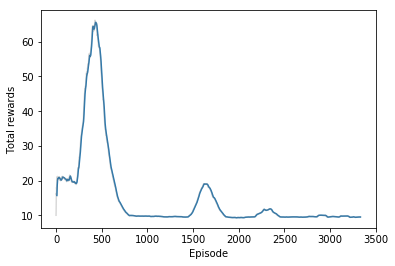

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

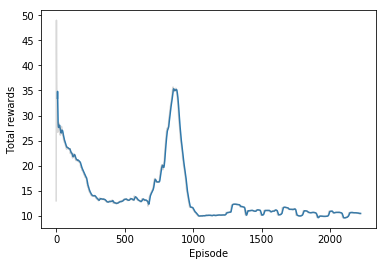

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

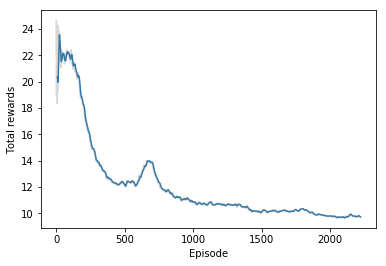

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

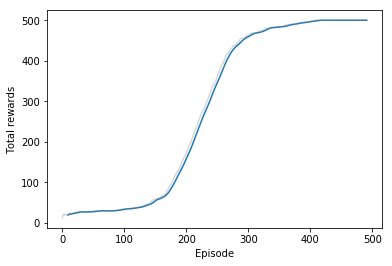

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

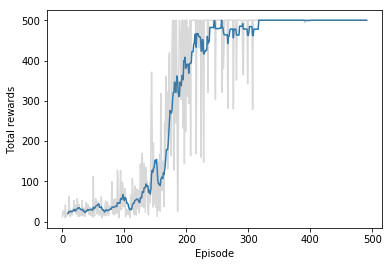

In [63]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.